In [3]:
import pandas as pd
import numpy as np
import pandas as pd
import math
import copy
from gamspy import (
    Container,Set,Alias,Parameter,Variable,Equation,Model,Problem,Sense,Options,
    Domain,Number,Sum,Product,Smax,Smin,Ord,Card,SpecialValues,
)
import gamspy.math as gpm
from matplotlib import pyplot as plt
import seaborn as sns

# Introduction

Air pollution is a critical environmental and public health challenge, especially in densely populated urban areas. Pollutants such as sulfur dioxide ($SO_2$), nitrogen oxides ($NO_x$), and particulate matter ($PM_x$) contribute to respiratory diseases and reduce overall environmental quality. This project aims to address air pollution control by developing an optimization framework to minimize pollution levels across multiple cities in France. The primary focus is on balancing pollution reduction and cost-effectiveness using integer optimization model.

The project leverages publicly available datasets on air pollution and control methods to build a robust optimization model. The model incorporates constraints to ensure pollutant levels are within acceptable thresholds while considering the costs of different pollution control equipment. Sensitivity analyses are performed to evaluate the effects of varying parameters, providing actionable insights for policymakers.


# Approach
To address this problem, the following approach is adopted:

1.	Data Structure: Use multi-dimensional datasets with cities, pollutants, and available equipment. The project uses two primary datasets:

  - The French air pollution dataset, publicly available at opendatasoft, which provides pollution data across various cities, including $SO_2$ and other pollutants.

  - Pollution control methods and associated costs/efficiency sourced from a relevant scientific study.
  
  Note that efficiency means how much pollution we can remove after we apply the pollution control methods.

  I display the data in the following cells.

2. Data Transformation:

  - Clean and prepare datasets for use in the optimization model.

3.	Optimization Variables:
  -	Binary variables to indicate the use of specific equipment in each city for each pollutant.
  -	Variables to capture post-processing pollutant levels.
4.	Objective Function:
  -	Minimize total post-treatment pollutant levels across all cities.
  -	Incorporate costs of equipment usage as a weighted parameter in the objective.
5.	Constraints:
  -	Ensure pollutant levels after treatment do not exceed predefined thresholds.
  -	Limit each city to using one piece of equipment per pollutant.
  -	Avoid assigning equipment with no efficiency for the pollutant.
6.	Sensitivity Analysis:
  -	Explore how varying cost weight in the objective function influences equipment selection and pollutant levels.


In [4]:
# Data
options = Options(equation_listing_limit=0,absolute_optimality_gap=0.999)
m = Container(options=options,load_from="France.gdx")

i, pollutant, equip, city_pollutant_value, cost, efficiency=m.getSymbols(['i','pollutant','equip','city_pollutant_value','cost','efficiency'])

print(f"Each city's pollutant level: {city_pollutant_value.records}\n")
print(f"Each equipment's cost: {cost.records}\n")
print(f"Each equipment's efficiency: {efficiency.records}")

Each city's pollutant level:                         i pollutant  value
0                    AGDE       NOx   8.60
1    AIR PAYS DE LA LOIRE       NOx   4.20
2    AIR PAYS DE LA LOIRE       PMx  25.80
3    AIR PAYS DE LA LOIRE       SO2   0.70
4                AIRVAULT       NOx   5.60
..                    ...       ...    ...
759                ÉPINAL       SO2   1.10
760                ÉVREUX       NOx  13.80
761                ÉVREUX       PMx  19.00
762                ÉVREUX       SO2   5.25
763    ÉVRY-COURCOURONNES       NOx  50.10

[764 rows x 3 columns]

Each equipment's cost:                                           equip pollutant      value
0                            Scrubbers-wet (SW)       PMx    262.000
1                                Bag house (BH)       PMx     85.000
2  Chemical suppressant-Magnesium chloride (CS)       PMx      0.490
3                        Water suppressant (WS)       PMx      0.350
4                                  Capping (Cp)       PMx     

# Optimization Model
$$
\begin{aligned}
\min_{x, \text{indicator}} &\sum_{i, pollutant} x[i, pollutant]
+ c \cdot \sum_{i, equip, pollutant} \text{cost}[equip, pollutant]
\cdot \text{indicator}[i, equip, pollutant],\\
\text{s.t.}, \quad
& x[i, pollutant] =
\sum_{equip} 0.01 \cdot (100 - \text{efficiency}[equip, pollutant])
\cdot \text{indicator}[i, equip, pollutant]
\cdot y[i, pollutant],\\
& 0 \leq x[i, pollutant]
\leq y[i, pollutant],\\
& \sum_{equip} \text{indicator}[i, equip, pollutant] = 1, \quad (\text{for all $y[i, pollutant] > 0$})\\
&\text{indicator}[i, equip, pollutant]  = 0, \quad (\text{for all $y[i, pollutant] = 0$ or $\text{efficiency}[equip, pollutant] = 0$})\\
& x = \text{post_pollutant_value},\\
& y = \text{city_pollutant_value},
\end{aligned}
$$
for $i$ in all cities and $pollutant$ in all types of pollutant.

## Variables
1.	$\text{indicator}[i, equip, pollutant]$: Binary variable indicating whether city $i$ uses equipment $equip$ for pollutant $pollutant$.
2.	$\text{post_pollutant_value}[i, pollutant]$: Positive variable capturing pollutant levels in city $i$ after treatment.

  And $c$ is a parameter that balance the weights between equipment removal efficiency and cost.

## Objective Function
Minimize the weighted sum of post-treatment pollutant levels and associated costs:

## Key Constraints
1.	Post-Treatment Pollution Calculation
2.	Pollution Level Bounds
3.	Equipment Selection:
  -	One piece of equipment per pollutant per city:
  -	Avoid non-functional equipment:



In [5]:

indicator = Variable(m, 'indicator', 'binary', domain=[i, equip, pollutant], description="Eech city can only use one equipment")
post_pollutant_value = Variable(m, 'post_pollutant_value', 'positive', domain=[i, pollutant], description="Each city's pollutant level after the processing")

post_pollutant = Equation(m, 'post_pollutant', domain=[i, pollutant])
post_pollutant[i, pollutant] = Sum(equip.where[efficiency[equip, pollutant] > 0], 0.01 * (100- efficiency[equip, pollutant]) * indicator[i, equip, pollutant] * city_pollutant_value[i, pollutant]) == post_pollutant_value[i, pollutant]

post_pollutant_cons = Equation(m, 'post_pollutant_cons', domain=[i, pollutant])
post_pollutant_cons[i, pollutant].where[city_pollutant_value[i, pollutant] > 0] = post_pollutant_value[i, pollutant] >= 0.0001

post_pollutant_less = Equation(m, 'post_pollutant_less', domain=[i, pollutant])
post_pollutant_less[i, pollutant].where[city_pollutant_value[i, pollutant] > 0] = post_pollutant_value[i, pollutant] <= city_pollutant_value[i, pollutant] - 0.001

method_cons = Equation(m, 'method_cons', domain=[i, pollutant])
method_cons[i, pollutant].where[city_pollutant_value[i, pollutant] > 0.01] = Sum(equip.where[efficiency[equip, pollutant] > 0], indicator[i, equip, pollutant]) == 1

method_cons_2 = Equation(m, 'method_cons_2', domain=[i, pollutant])
method_cons_2[i, pollutant].where[city_pollutant_value[i, pollutant] <= 0.01] = Sum(equip, indicator[i, equip, pollutant]) == 0

method_cons_3 = Equation(m, 'method_cons_3', domain=[i, pollutant])
method_cons_3[i, pollutant]= Sum(equip.where[efficiency[equip, pollutant] == 0], indicator[i, equip, pollutant]) == 0

obj = Sum([i, pollutant], post_pollutant_value[i, pollutant]) + 0.001 * Sum([i, equip, pollutant], cost[equip, pollutant] * indicator[i, equip, pollutant])

france_pollutant = Model(m,
            name="france_pollutant",
            equations=m.getEquations(),
            problem=Problem.MIP,
            sense=Sense.MIN,
            objective=obj)

france_pollutant.solve()


,Solver Status,Model Status,Objective,Num of Equations,Num of Variables,Model Type,Solver,Solver Time
0,Normal,OptimalGlobal,2544.7787336991,5093,13135,MIP,CPLEX,0.106


<ipython-input-6-75f20b0097f3>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df = pd.merge(efficiency.records, indicator.records, on="equip", how="inner").groupby("equip")["level"].sum()


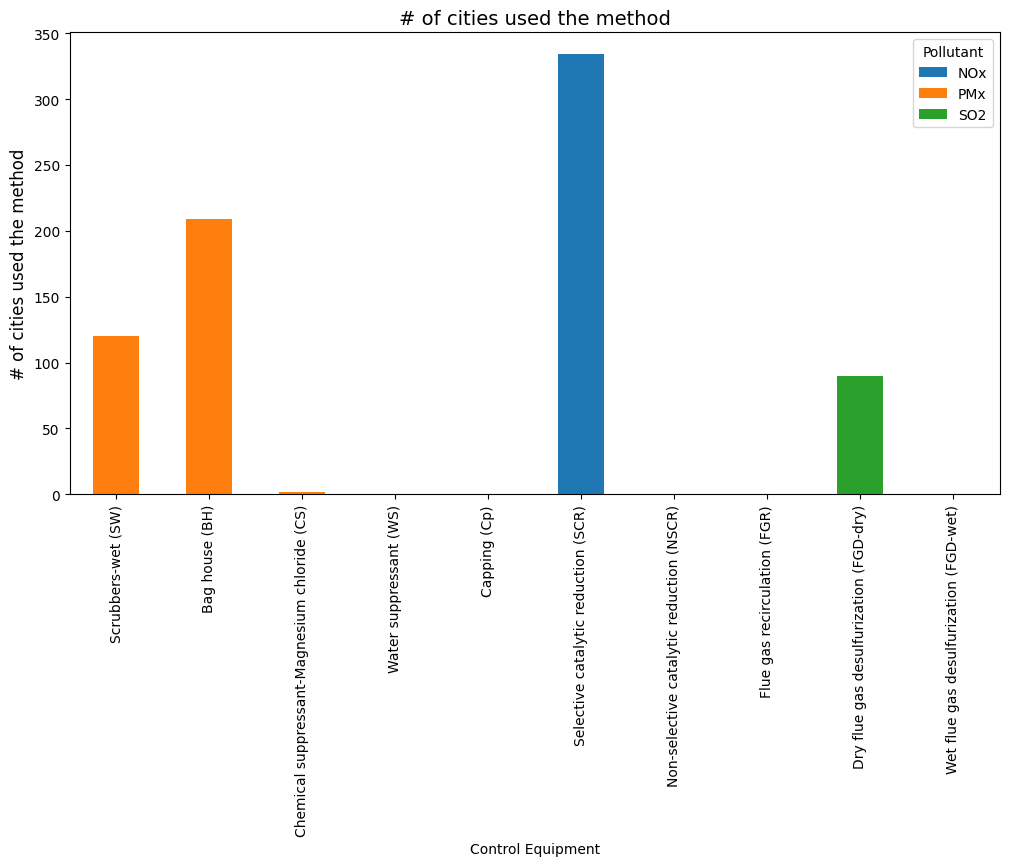

In [6]:
merged_df = pd.merge(efficiency.records, indicator.records, on="equip", how="inner").groupby("equip")["level"].sum()
merged_df = pd.merge(efficiency.records, merged_df, on = "equip", how = "left")[["equip", "pollutant", "level"]]
pivot_df = merged_df.pivot(index='equip', columns='pollutant', values='level')
ax = pivot_df.plot.bar(stacked=True, figsize=(12, 6))

# Customize the plot
ax.set_xlabel("Control Equipment", fontsize=10)
ax.set_ylabel("# of cities used the method", fontsize=12)
ax.set_title("# of cities used the method", fontsize=14)
ax.set_xticks(ax.get_xticks())  # Ensure x-ticks are set properly
ax.set_xticklabels(pivot_df.index, rotation=90, fontsize=10)  # Rotate x-axis labels
ax.legend(title="Pollutant", fontsize=10)

plt.show()

# Solution and Analysis
The optimization model was solved using mixed-integer programming. Key results include:
Equipment Usage: Distribution of equipment selection for pollutants across cities. Since in our objective function, we assign more weight on the post pollution levels and less weight on equipment cost, we can see that in PM removal part, the equipments are selected more on the ones with high removal efficiency rather than cheaper cost. And also the case for NOx removal equipment. However, it is not the case for SO2 removal, since the removal efficiency is not very different between the two equipment in that class.

Then, there is a natural question: "Will the selection stretegy changed when we change the weights in the objective function? (more focus on efficiency or cost)".

We design the following sensitivity analysis:

The impact of varying cost weights in the objective function was examined. A range of values for the cost parameters, i.e. $c$ in the objective function, ([0, 0.001, 0.01, 0.1, 1, 10]) are applied to observe changes in equipment selection patterns: higher cost weight reduces expensive equipment usage.


<ipython-input-7-e67d8e3ce57f>:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df = pd.merge(efficiency.records, indicator.records, on="equip", how="inner").groupby("equip")["level"].sum()
<ipython-input-7-e67d8e3ce57f>:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df = pd.merge(efficiency.records, indicator.records, on="equip", how="inner").groupby("equip")["level"].sum()
<ipython-input-7-e67d8e3ce57f>:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to 

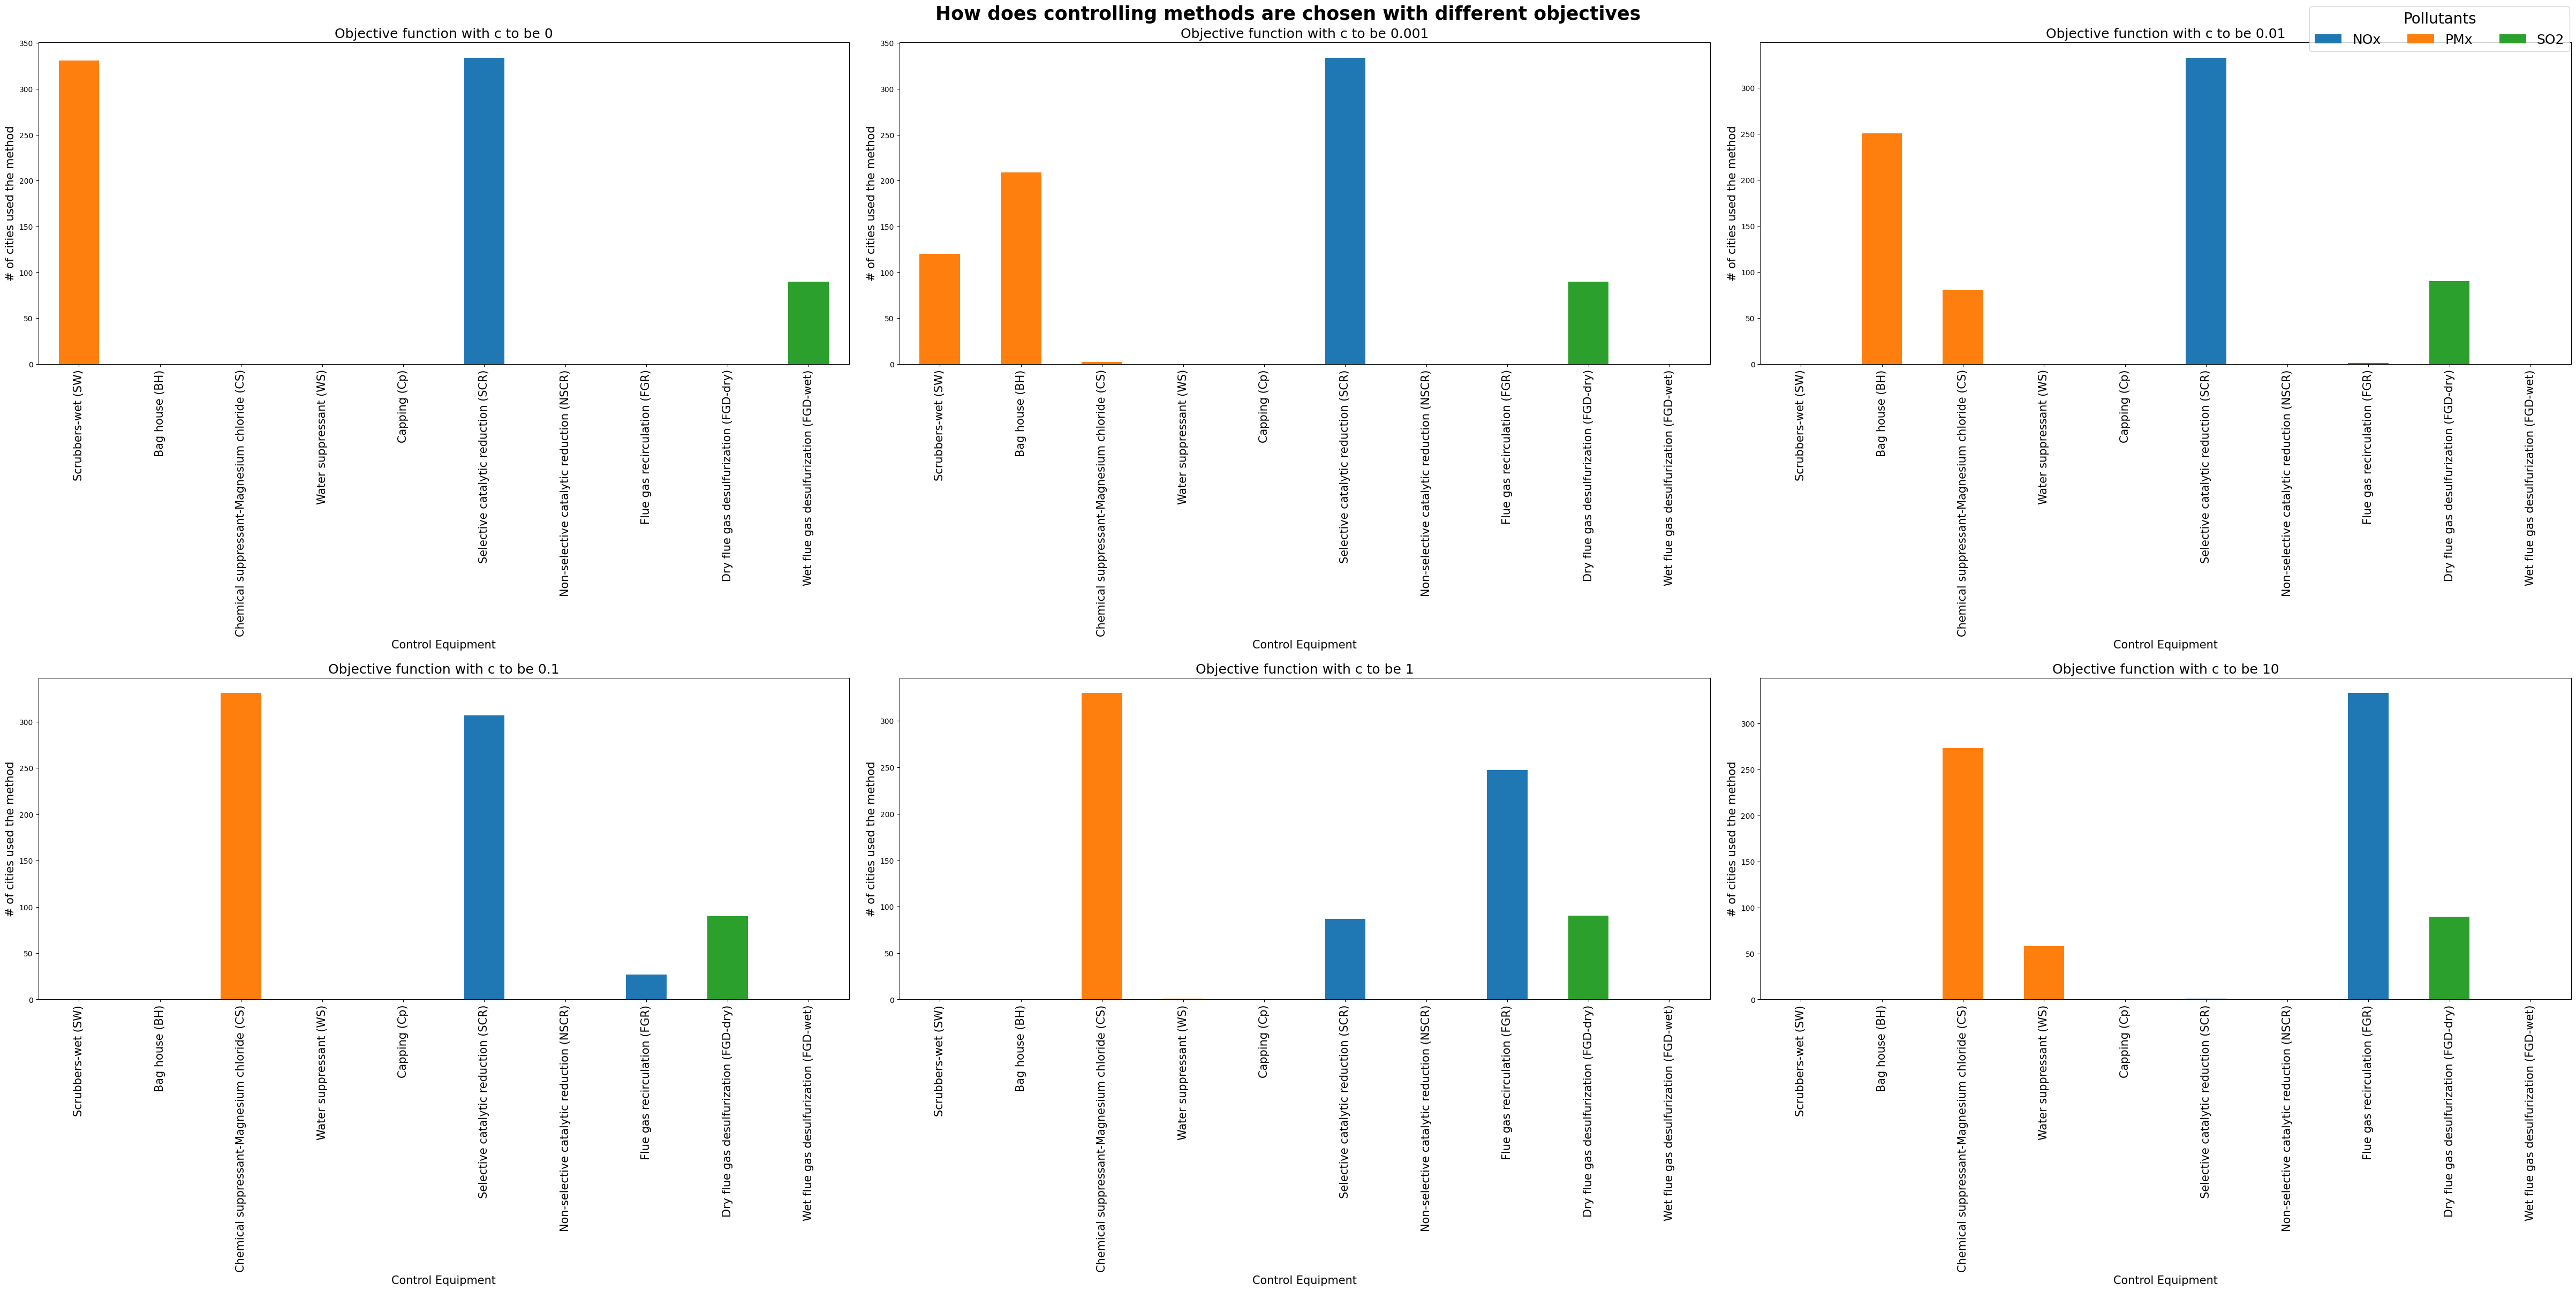

In [7]:
def generate_plot(params_list):

  n = len(params_list)
  cols = int(np.ceil(np.sqrt(n)))
  rows = int(np.ceil(n / cols))

  # Create figure for subplots
  fig, axes = plt.subplots(rows, cols, figsize=(cols * 16, rows * 12), constrained_layout=True)
  axes = axes.flatten()
  handles_list = []
  labels_list = []

  for idx in range(len(params_list)):
    param = params_list[idx]
    obj = Sum([i, pollutant], post_pollutant_value[i, pollutant]) + param * Sum([i, equip, pollutant], cost[equip, pollutant] * indicator[i, equip, pollutant])

    france_pollutant = Model(m,
                name="france_pollutant",
                equations=m.getEquations(),
                problem=Problem.MIP,
                sense=Sense.MIN,
                objective=obj)

    france_pollutant.solve()

    merged_df = pd.merge(efficiency.records, indicator.records, on="equip", how="inner").groupby("equip")["level"].sum()
    merged_df = pd.merge(efficiency.records, merged_df, on = "equip", how = "left")[["equip", "pollutant", "level"]]
    pivot_df = merged_df.pivot(index='equip', columns='pollutant', values='level')
    ax = axes[idx]
    pivot_df.plot.bar(stacked=True, ax=ax, legend=False)

    # Customize the plot
    ax.set_xlabel("Control Equipment", fontsize=15)
    ax.set_ylabel("# of cities used the method", fontsize=15)
    ax.set_title(f"Objective function with c to be {param}", fontsize=18)
    ax.set_xticks(range(len(pivot_df.index)))
    ax.set_xticklabels(pivot_df.index, rotation=90, fontsize=15)

    handles, labels = ax.get_legend_handles_labels()
    handles_list.extend(handles)
    labels_list.extend(labels)

  unique_handles_labels = {label: handle for handle, label in zip(handles_list, labels_list)}
  fig.legend(unique_handles_labels.values(),
              unique_handles_labels.keys(),
              loc="upper right",
              ncol=3,
              fontsize=18,
              title="Pollutants",
             title_fontsize=20)

  for ax in axes[len(params_list):]:
    ax.axis('off')

  fig.suptitle("How does controlling methods are chosen with different objectives", fontsize=25, fontweight="bold")
  plt.savefig("How does controlling method is chosen with different objectives.png")
  plt.show()

generate_plot([0, 0.001, 0.01, 0.1, 1, 10])

As you can see above, as the $c$ increases, the cost weigh higher in the objective function than the efficiency, then cheaper equipments dominant the selection.

# Conclusion
The project demonstrates that using optimization models can effectively manage pollution control decision problem across cities. The model ensures pollutant levels are minimized while balancing cost considerations. Sensitivity analysis highlights the trade-offs between cost efficiency and pollutant reduction which can guide the pollution control assignment efficiently.


# Extensions and Future Work
1.	Incorporate dynamic pollutant levels based on temporal changes.
2.	Evaluate the environmental and health impacts of reduced pollution levels.
3.	Expand the model to include additional pollutants and equipment types.
5.  Use minimax formulation to balance each city's pollution level.